# Session 7. 지도학습2
## Decision Tree / Support Vector Machine / Random Foreset / XGBoost

#### 작성자: 5기 공채린
#### 퀘스트 기한: 2019. 10. 13 (일) 23:59

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [15]:
df = pd.read_csv('AB_NYC_2019.csv', encoding='utf-8')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


뉴욕의 에어비엔비 데이터셋을 활용하여 방 타입, 숙박 가격, 최소숙박일수, 최근리뷰, 월 리뷰갯수 등으로부터 숙소의 위치를 알아내는 모델

편의상 맨하튼, 브루클린의 숙소들로 범위를 좁혔습니다

In [16]:
our_set = df[df['neighbourhood_group'].isin(['Brooklyn', 'Manhattan'])]
our_set.shape, df.shape

((41765, 16), (48895, 16))

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

### 전체적인 가격대 분포 살펴보기

Text(0, 0.5, 'Ratio')

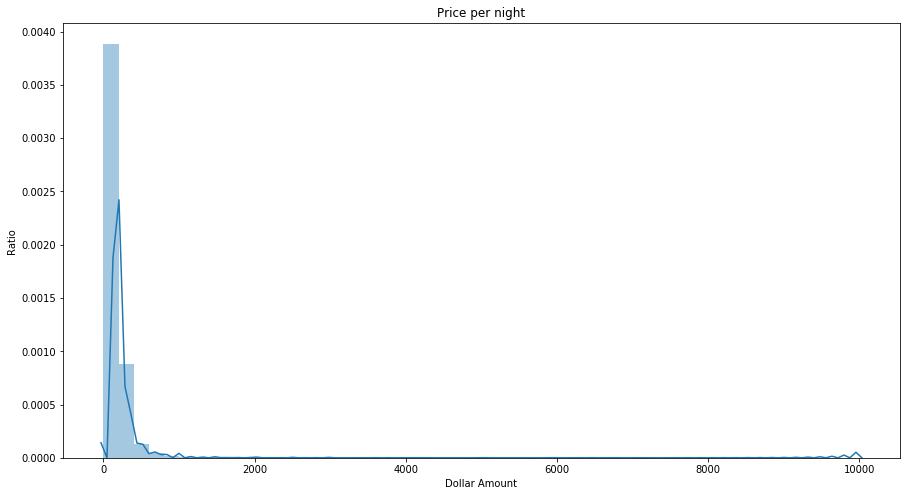

In [18]:
plt.figure(figsize=(15,8))
sns.distplot(our_set['price'])
plt.title("Price per night")
plt.xlabel('Dollar Amount')
plt.ylabel('Ratio')

Text(0, 0.5, 'Ratio')

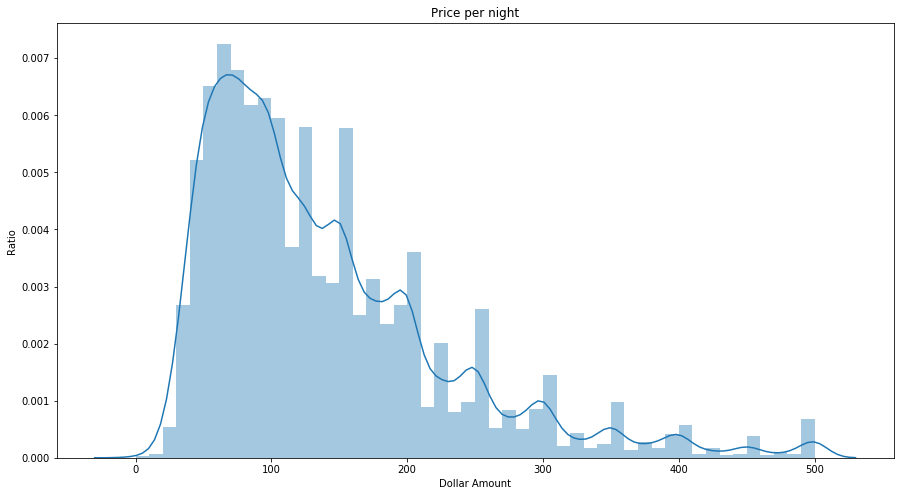

In [19]:
plt.figure(figsize=(15,8))
sns.distplot(our_set[our_set['price']<=500]['price'])
plt.title("Price per night")
plt.xlabel('Dollar Amount')
plt.ylabel('Ratio')

### 방 타입에는 어떤 것들이 있나...

In [20]:
set(our_set['room_type']) #room_type 에는 뭐가 있나(unique 한 값)

{'Entire home/apt', 'Private room', 'Shared room'}

In [21]:
import random

random_seed = random.randint(0,1000) #0 에서 1000 사이의 난수 뽑기
random_seed

553

### 자연어를 기계가 알아들을 수 있게 수치로 변환

In [22]:
our_set = our_set.replace('Brooklyn', 0).replace('Manhattan', 1)

### 룸 타입 역시 자연어로 되어있으므로, "원핫인코딩"을 통해 수치로 변환

In [23]:
#원핫인코딩: 한 기준의 여러 분류 값들을 여러개의 칼럼으로 분해
#ex. 학교 칼럼의 값들 초, 중, 고, 대 -> 칼럼: 초, 중, 고, 대
x = pd.get_dummies(our_set['room_type'])
core_cols = our_set[['neighbourhood_group', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']]
combined = core_cols.merge(x, left_index=True, right_index=True, how='left').reset_index() #merge 옆으로 join
combined.head()

,index,neighbourhood_group,price,minimum_nights,number_of_reviews,reviews_per_month,Entire home/apt,Private room,Shared room
0,0,0,149,1,9,0.21,0,1,0
1,1,1,225,1,45,0.38,1,0,0
2,2,1,150,3,0,NaN,0,1,0
3,3,0,89,1,270,4.64,1,0,0
4,4,1,80,10,9,0.10,1,0,0


### 불필요한 컬럼 제거, 결측치 제외

In [24]:
final = combined.drop(columns=['index']).dropna() #na 가 하나라도 있는 행을 다 버림
final.shape

(33079, 8)

In [25]:
### 혹시 아직 결측치가 남아있는지 최종 점검
#console창에서 pip 해야함
import missingno as msno
msno.matrix(final) #결측치가 없어서 가로 선 없음. 
#결측치 있으면 가로선으로 어떤 컬럼에 어떤 위치에 결측치 있는지 보임

ModuleNotFoundError: No module named 'missingno'

In [26]:
final.head() #neighbourhood group 브루클린은 0, 맨해튼은 1

,neighbourhood_group,price,minimum_nights,number_of_reviews,reviews_per_month,Entire home/apt,Private room,Shared room
0,0,149,1,9,0.21,0,1,0
1,1,225,1,45,0.38,1,0,0
3,0,89,1,270,4.64,1,0,0
4,1,80,10,9,0.10,1,0,0
5,1,200,3,74,0.59,1,0,0


In [27]:
#github 에서 내용 추가 됨
#https://github,com/reyllama/GHsession

### 본격적인 모델링

In [28]:
### 랜덤 시드를 활용하여 트레인, 테스트셋 분리 / 3:1 비율로

from sklearn.model_selection import train_test_split
#x_train 은 y 를 얻기 위해 쓸 변수
#random 으로 뽑을 것을 시간 주리기 위해 미리 뽑은 random_seed 이용
X_train, X_test, y_train, y_test = train_test_split(final[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']], final['neighbourhood_group'], 
                                                    test_size=0.25, random_state=random_seed)

In [29]:
### 랜덤포레스트 모델 수립, 대충 하이퍼 파라미터 제공
import time
from sklearn.ensemble import RandomForestClassifier
random_seed = random.randint(0,1000)
rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=random_seed)
#나무를 200개 만들겠다
### 학습 진행
t0 = time.time()
rf.fit(X_train, y_train)
elapsed = time.time()-t0
print("걸린시간은 {:.2f}초입니다.".format(elapsed))


걸린시간은 16.08초입니다.


In [30]:
from sklearn.metrics import accuracy_score

#train set 으로 학습했던 거를 이제 x_test에 적용
### 학습된 모델로 분류 예측
prediction = rf.predict(X_test)
### 채점
accuracy = accuracy_score(y_test, prediction)
#y_test 는 우리가 갖고 있던 정답, prediction 은 x_test 로 predict 한 것
### 성적 발표
print(f'Mean accuracy score: {100*accuracy:.3}%')

Mean accuracy score: 61.3%


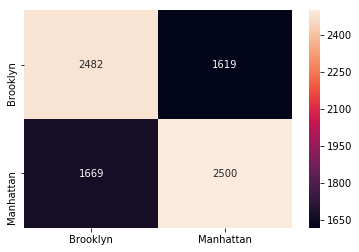

In [31]:
### 오답/정답 시각화를 위한 간단한 히트맵
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test, prediction), columns=['Brooklyn', 'Manhattan'], index=['Brooklyn', 'Manhattan'])
sns.heatmap(cm, annot=True, fmt='d')
#x축은 정답, y축은 대답

In [ ]:
#github 에 내용 추가
#command에서 pip install xgboost 하고 
#xgboost 만드는 방법 소개 되어있는 코드 실행해보기

# ★퀘스트★

### 오늘 배운 모델들을 활용하여 (DT, SVM, XGBOOST / RF는 제외!!) 이보다 더 정교한 모델을 만들어보아요.
### 목표는 정확도 > 60%

(+추가)
같은 모델이더라도, 하이퍼 파라미터를 바꿔가며 코드를 실행해보면 결과가 달라집니다. 

time 모듈을 활용하여 각 모델별로 걸리는 시간도 측정해보아요.

생각보다 높은 정확도를 기록하였다면, 캐글에도 한번 등록해보아요. (https://kaggle.com)

모르는 게 있으면 질문도 좋습니다.

In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
df = pd.read_csv('AB_NYC_2019.csv', encoding='utf-8')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [33]:
our_set = df[df['neighbourhood_group'].isin(['Brooklyn', 'Manhattan'])]
our_set = our_set.replace('Brooklyn', 0).replace('Manhattan', 1)

x = pd.get_dummies(our_set['room_type'])
core_cols = our_set[['neighbourhood_group', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']]
combined = core_cols.merge(x, left_index=True, right_index=True, how='left').reset_index()

final = combined.drop(columns=['index']).dropna()

In [34]:
from sklearn.model_selection import train_test_split
import random

random_seed = random.randint(0,1000)

X_train, X_test, y_train, y_test = train_test_split(final[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']], final['neighbourhood_group'], 
                                                    test_size=0.25, random_state=random_seed)

In [57]:
from sklearn.svm import SVC

t0 = time.time()
svc=SVC()
svc.fit(X_train, y_train)
elapsed = time.time()-t0
print("걸린시간은 {:.2f}초입니다.".format(elapsed))

C:\Users\hyunk\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


걸린시간은 197.97초입니다.


In [58]:
from sklearn.metrics import accuracy_score


prediction = svc.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

print(f'Mean accuracy score: {100*accuracy:.3}%')

Mean accuracy score: 59.7%


In [59]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scale=scaler.fit_transform(X_train)

In [60]:
svc.fit(X_train_scale,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [61]:
prediction = svc.predict(X_test)
### 채점
accuracy = accuracy_score(y_test, prediction)
#y_test 는 우리가 갖고 있던 정답, prediction 은 x_test 로 predict 한 것
### 성적 발표
print(f'Mean accuracy score: {100*accuracy:.3}%')

Mean accuracy score: 50.1%
